In [1]:
using DrWatson
@quickactivate projectdir()

In [2]:
include(srcdir("rdpg.jl"))
using Main.rdpg
using StatsBase, Pipe, Graphs, GraphIO, LightGraphs, DelimitedFiles, Random
using ProgressMeter, DataFrames
using Plots, Ripserer, PersistenceDiagrams, PersistenceDiagramsBase
using Distances, LinearAlgebra, UMAP
using SparseArrays

In [3]:
function read_graph(; path, delim='\t', labels=nothing)
    data = Int.(readdlm(path, delim))
    if labels !== nothing
        rownames = labels[:, 1]
        n = length(unique(data))
        indx = map(i -> findall(j -> j == i, rownames), data)
        A = sparse(indx[:, 1], indx[:, 2], Int(1), n, n)
    else
        tmp = unique(data)
        n = length(tmp)
        data .= minimum(tmp) != 1 ? data .+ 1 : data
        A = sparse(data[:, 1], data[:, 2], Int(1), n, n)
    end
    return A |> LightGraphs.LinAlg.symmetrize
end

read_graph (generic function with 1 method)

In [4]:
dim = 100
n = 20000
subsample = true
path_to_graph = datadir("large_twitch_edges.csv")
path_to_labels = datadir("large_twitch_features.csv")

"/storage/work/s/suv87/julia/dp-rdpg/data/large_twitch_features.csv"

In [5]:
labels, cols = readdlm(path_to_labels, ',', header=true)
langs = labels[:, 8]
Adjacency = read_graph(path=path_to_graph, delim=',', labels=nothing)

168114×168114 SparseMatrixCSC{Int64, Int64} with 13595114 stored entries:
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿

In [6]:
subsample = false
downsample = true

true

In [7]:
if subsample
    subsample_indices = sample(eachindex(langs), n, replace=false)
    Adjacency = Adjacency[subsample_indices, subsample_indices]
    langs = langs[subsample_indices]
    labels = labels[subsample_indices, :]
end

In [8]:
if !downsample

    ind1 = findall(i -> langs[i] ∈ ["FR", "RU", "ZH"], eachindex(langs))
    indx = sample(ind1, min(length(ind1), 2000), replace=false)
    labs = labels[:, :]

    A = copy(Adjacency)
    Xhat, _ = rdpg.spectralEmbed(A, d=dim, scale=false)

else

    ind1 = findall(i -> langs[i] ∈ ["FR", "RU", "ZH"], eachindex(langs))
    indx = sample(eachindex(ind1), min(length(ind1), 2000), replace=false)

    labs = labels[ind1, :]
    A = copy(Adjacency)[ind1, ind1]
    Xhat, _ = rdpg.spectralEmbed(A, d=dim, scale=false)

end;

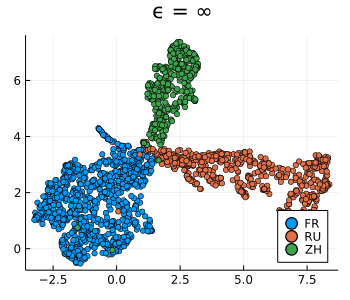

In [9]:
Xnh = Xhat[indx, :]

embedding_umap_x = umap(Xnh', 2; n_neighbors=25, metric=Euclidean())'

plt_umap_x = scatter(
    embedding_umap_x |> rdpg._Matrix_to_ArrayOfTuples,
    ms=3, legend=:bottomright, size=(350, 300),# lim=(-12, 12),
    group=labs[indx, 8],
    title="ϵ = ∞"
)

In [10]:
savefig(plotsdir("twitch/plt_umap_x.svg"));
savefig(plotsdir("twitch/plt_umap_x.pdf"))

In [11]:
ϵ = log(size(A, 1))


B = (rdpg.edgeFlip(A, ϵ=ϵ) .- rdpg.τ(ϵ)) ./ rdpg.σ(ϵ)^2
Yhat, _ = rdpg.spectralEmbed(B, d=dim, scale=false)
Ynh1 = Yhat[indx, :];

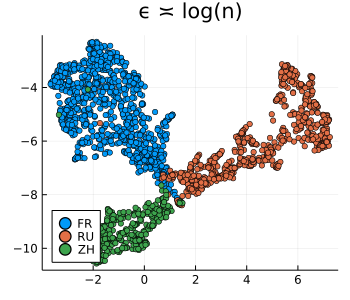

In [12]:
embedding_umap_y1 = umap(Ynh1', 2; n_neighbors=25, metric=Euclidean())'

plt_umap_y1 = scatter(
    embedding_umap_y1 |> rdpg._Matrix_to_ArrayOfTuples,
    ms=3, legend=:bottomleft, size=(350, 300),# lim=(-12, 12),
    group=labs[indx, 8],
    title="ϵ ≍ log(n)"
)

In [13]:
savefig(plotsdir("twitch/plt_umap_y1.pdf"))
savefig(plotsdir("twitch/plt_umap_y1.svg"))

In [14]:
ϵ = log(size(A, 1)) - log(log(size(A, 1)))


B = (rdpg.edgeFlip(A, ϵ=ϵ) .- rdpg.τ(ϵ)) ./ rdpg.σ(ϵ)^2
Yhat, _ = rdpg.spectralEmbed(B, d=dim, scale=false)
Ynh2 = Yhat[indx, :];

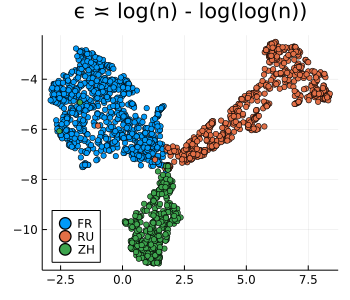

In [15]:
embedding_umap_y2 = umap(Ynh2', 2; n_neighbors=25, metric=Euclidean())'

plt_umap_y2 = scatter(
    embedding_umap_y2 |> rdpg._Matrix_to_ArrayOfTuples,
    ms=3, legend=:bottomleft, size=(350, 300),# lim=(-12, 12),
    group=labs[indx, 8],
    title="ϵ ≍ log(n) - log(log(n))"
)

In [16]:
savefig(plotsdir("twitch/embedding_umap_y2.pdf"))
savefig(plotsdir("twitch/embedding_umap_y2.svg"))

In [17]:
ϵ = log(log(size(A, 1)))



B = (rdpg.edgeFlip(A, ϵ=ϵ) .- rdpg.τ(ϵ)) ./ rdpg.σ(ϵ)^2
Yhat, _ = rdpg.spectralEmbed(B, d=dim, scale=false)
Ynh3 = Yhat[indx, :];

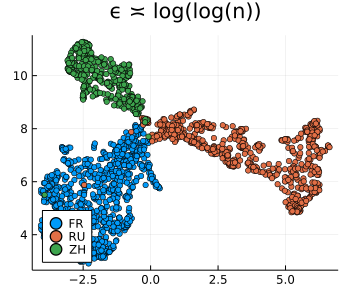

In [18]:
embedding_umap_y3 = umap(Ynh3', 2; n_neighbors=25, metric=Euclidean())'

plt_umap_y3 = scatter(
    embedding_umap_y3 |> rdpg._Matrix_to_ArrayOfTuples,
    ms=3, legend=:bottomleft, size=(350, 300),# lim=(-12, 12),
    group=labs[indx, 8],
    title="ϵ ≍ log(log(n))"
)

In [19]:
savefig(plotsdir("twitch/embedding_umap_y3.pdf"))
savefig(plotsdir("twitch/embedding_umap_y3.svg"))